In [1]:
import pandas as pd
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer
import keras

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os

import math


from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import datetime as dt

import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # turn off deprecation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


2023-04-16 21:31:33.460046: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:31:33.524126: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:31:33.525164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 21:31:34.463246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Prepare Data

In [2]:
df = pd.read_csv('../../data/final_dataset.csv')
df.drop(columns=['Unnamed: 0.1','Unnamed: 0','datetime'], inplace=True)
df

,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,...,vi_pos,vi_neg,ALU,XCU,BRENTOIL,NG,XAU,IRD,ETHANOL,CORN
0,47224.54,47231.61,47215.29,47227.56,12.33375,1641121139999,5.824030e+05,458,9.72943,459425.952954,...,0.916481,1.074392,0.087934,0.278236,77.715496,3.728471,0.000547,4146.516926,2.136295,5.925674
1,47227.57,47227.57,47140.30,47188.89,36.98943,1641121199999,1.745224e+06,895,10.47851,494227.783150,...,0.832151,1.079854,0.087934,0.278236,77.715496,3.728471,0.000547,4146.516926,2.136295,5.925674
2,47188.88,47188.89,47159.57,47163.75,5.48303,1641121259999,2.586577e+05,457,2.32043,109462.466918,...,0.855032,1.123661,0.087934,0.278236,77.715496,3.728471,0.000547,4146.516926,2.136295,5.925674
3,47163.75,47200.00,47162.97,47199.99,9.95895,1641121319999,4.698914e+05,422,5.53526,261162.816818,...,0.869207,1.091204,0.087934,0.278236,77.715496,3.728471,0.000547,4146.516926,2.136295,5.925674
4,47199.99,47221.10,47196.78,47216.96,10.41996,1641121379999,4.919137e+05,482,4.60476,217382.281408,...,0.908495,1.077247,0.087934,0.278236,77.715496,3.728471,0.000547,4146.516926,2.136295,5.925674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661279,28025.70,28025.70,28014.49,28022.37,9.24773,1680809579999,2.591298e+05,500,5.48468,153679.496830,...,1.227767,0.770152,0.073823,0.248594,84.940000,2.094000,0.000495,4600.000000,2.161000,6.537500
661280,28022.38,28040.00,28022.37,28039.99,24.89461,1680809639999,6.978784e+05,783,20.72318,580932.984723,...,1.247251,0.742413,0.073823,0.248594,84.940000,2.094000,0.000495,4600.000000,2.161000,6.537500
661281,28040.00,28040.00,28026.30,28026.31,12.50605,1680809699999,3.505753e+05,473,3.56029,99790.897540,...,1.227910,0.786317,0.073823,0.248594,84.940000,2.094000,0.000495,4600.000000,2.161000,6.537500
661282,28026.31,28046.22,28026.30,28039.43,36.30931,1680809759999,1.018126e+06,762,19.78056,554594.460956,...,1.152489,0.802175,0.073823,0.248594,84.940000,2.094000,0.000495,4600.000000,2.161000,6.537500


In [3]:
scaler = MinMaxScaler()


# Fit the scaler on your dataframe (let's say it's called df)
df_normalized = scaler.fit_transform(df)

# Convert the normalized data back to a dataframe
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)

In [4]:

# Convert the DataFrame to a NumPy array
raw_data = df_normalized.values
close = df_normalized['close'].values
close = close.reshape((len(close),1))
# Display the NumPy array
print(type(raw_data))
print(raw_data.shape)
print(close.shape)

<class 'numpy.ndarray'>
(661284, 84)
(661284, 1)


# Prepare Model

In [5]:
print('Prep Data')
num_train_samples = int(0.6 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


Prep Data
num_train_samples: 396770
num_val_samples: 165321
num_test_samples: 99193


In [6]:
# Set Parameters

# delay: time in future that will be predicted
delay = 6 * 60


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 30

# sequence length: sequence lenght of each sample
half_day = 12 * 60
sequence_length = int(4 * half_day / sampling_rate)


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 5

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 64

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future, and will have data from {sequence_length * sampling_rate} timesteps in the past"
print(msg)

The timeseries will consist of batches containing 64 sequences of 96 samples.
Finally our target is 360 timesteps in the future, and will have data from 2880 timesteps in the past


In [7]:
train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                        raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")

2023-04-16 21:31:49.052152: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 266629440 exceeds 10% of free system memory.


Done Train
Done Validation
Done Test


# Build and Train Model

In [8]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)


outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("models/lstm",
   save_best_only=True) 
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)


2023-04-16 21:31:49.829936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:31:49.831778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:31:49.833075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-04-16 21:31:50.140687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [396770,84]
	 [[{{node Placeholder/_0}}]]
2023-04-16 21:31:50.141235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [396770,84]
	 [[{{node Placeholder/_0}}]]
2023-04-16 21:31:50.505077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

1231/1231 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0290

2023-04-16 21:32:30.774145: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 111095712 exceeds 10% of free system memory.
2023-04-16 21:32:30.794513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [32489]
	 [[{{node Placeholder/_8}}]]
2023-04-16 21:32:30.795074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-16 21:32:31.130953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this

1231/1231 [==============================] - 52s 40ms/step - loss: 0.0019 - mae: 0.0290 - val_loss: 0.0037 - val_mae: 0.0552
Epoch 2/20
1231/1231 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0211

2023-04-16 21:33:27.443558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:33:27.445584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:33:27.447065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1231/1231 [==============================] - 49s 40ms/step - loss: 0.0023 - mae: 0.0211 - val_loss: 0.0027 - val_mae: 0.0488
Epoch 3/20
1231/1231 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0197

2023-04-16 21:34:49.654816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:34:49.656496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:34:49.657836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1231/1231 [==============================] - 49s 40ms/step - loss: 0.0021 - mae: 0.0197 - val_loss: 0.0020 - val_mae: 0.0414
Epoch 4/20
1231/1231 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0180

2023-04-16 21:35:39.038247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:35:39.040225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:35:39.041740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1231/1231 [==============================] - 50s 40ms/step - loss: 0.0017 - mae: 0.0180 - val_loss: 0.0014 - val_mae: 0.0346
Epoch 5/20
1231/1231 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0167

2023-04-16 21:36:28.706362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:36:28.708214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:36:28.709674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1231/1231 [==============================] - 49s 40ms/step - loss: 0.0013 - mae: 0.0167 - val_loss: 9.9971e-04 - val_mae: 0.0284
Epoch 6/20
1231/1231 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0158

2023-04-16 21:37:50.488778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:37:50.493696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:37:50.495122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1231/1231 [==============================] - 49s 40ms/step - loss: 0.0011 - mae: 0.0158 - val_loss: 6.9592e-04 - val_mae: 0.0221
Epoch 7/20
1231/1231 [==============================] - ETA: 0s - loss: 9.1205e-04 - mae: 0.0148

2023-04-16 21:38:39.534717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:38:39.536792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:38:39.538237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1231/1231 [==============================] - 49s 40ms/step - loss: 9.1205e-04 - mae: 0.0148 - val_loss: 5.2046e-04 - val_mae: 0.0175
Epoch 8/20
1231/1231 [==============================] - ETA: 0s - loss: 7.7538e-04 - mae: 0.0141

2023-04-16 21:39:29.225216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:39:29.227264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:39:29.228631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1231/1231 [==============================] - 49s 40ms/step - loss: 7.7538e-04 - mae: 0.0141 - val_loss: 4.3584e-04 - val_mae: 0.0153
Epoch 9/20
1231/1231 [==============================] - ETA: 0s - loss: 6.7000e-04 - mae: 0.0136

2023-04-16 21:40:18.508553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:40:18.510622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:40:18.512056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1231/1231 [==============================] - 50s 40ms/step - loss: 6.7000e-04 - mae: 0.0136 - val_loss: 4.0945e-04 - val_mae: 0.0155
Epoch 10/20
1231/1231 [==============================] - 46s 37ms/step - loss: 5.8595e-04 - mae: 0.0132 - val_loss: 4.2072e-04 - val_mae: 0.0168
Epoch 11/20
1231/1231 [==============================] - 45s 37ms/step - loss: 5.1694e-04 - mae: 0.0128 - val_loss: 4.6181e-04 - val_mae: 0.0185
Epoch 12/20
1231/1231 [==============================] - 46s 37ms/step - loss: 4.6213e-04 - mae: 0.0126 - val_loss: 5.2322e-04 - val_mae: 0.0202
Epoch 13/20
1231/1231 [==============================] - 46s 37ms/step - loss: 4.1860e-04 - mae: 0.0123 - val_loss: 5.7115e-04 - val_mae: 0.0212
Epoch 14/20
1231/1231 [==============================] - 45s 37ms/step - loss: 3.8636e-04 - mae: 0.0122 - val_loss: 6.1980e-04 - val_mae: 0.0221
Epoch 15/20
1231/1231 [==============================] - 46s 37ms/step - loss: 3.6381e-04 - mae: 0.0120 - val_loss: 6.6069e-04 - val_mae: 0.02

In [9]:
# Save the trained model to a file
model.save('lstm_model_1.h5')

# Understanding the Model

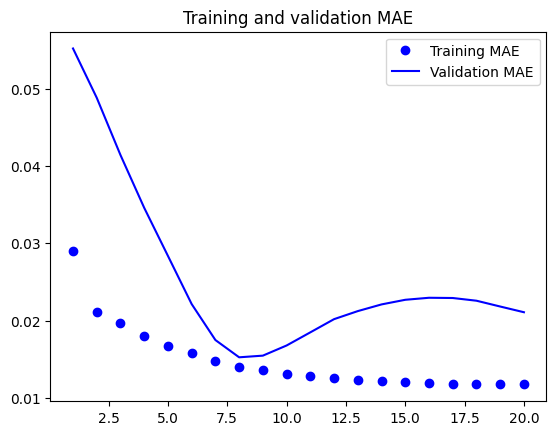

In [10]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Looking at the data

In [11]:
pred_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=1,
                    sequence_stride=1,
                    sequence_length=180,
                    shuffle=False, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=32,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples
                    )



                    

2023-04-16 21:49:56.796635: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 444140928 exceeds 10% of free system memory.


In [12]:


predictions = model.predict(pred_dataset)

2023-04-16 21:49:57.528250: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 444140928 exceeds 10% of free system memory.
2023-04-16 21:49:57.948550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-16 21:49:57.949105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [660924,1]
	 [[{{node Placeholder/_20}}]]


    1/20649 [..............................] - ETA: 5:29:22

2023-04-16 21:49:58.331567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:49:58.333673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:49:58.335245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20649/20649 [==============================] - 347s 17ms/step


In [13]:
print(len(predictions) )
print(len(close[:660745]))


660745
660745


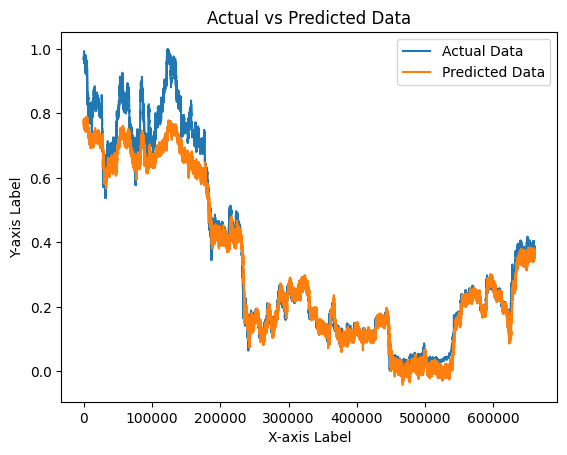

In [14]:
# Generate the predictions using your model and store it in a variable called 'predictions'

# Plot the actual data
plt.plot(range(len(predictions)), close[num_train_samples+180:num_train_samples + num_val_samples+1], label='Actual Data')

# Plot the predicted data
plt.plot(range(len(predictions)), predictions, label='Predicted Data')

# Add labels, title, and legend
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Actual vs Predicted Data')
plt.legend()

# Display the plot
plt.show()

In [36]:
print(num_train_samples)

396770


72000
72000
144000


ValueError: x and y must have same first dimension, but have shapes (21142,) and (72000, 1)

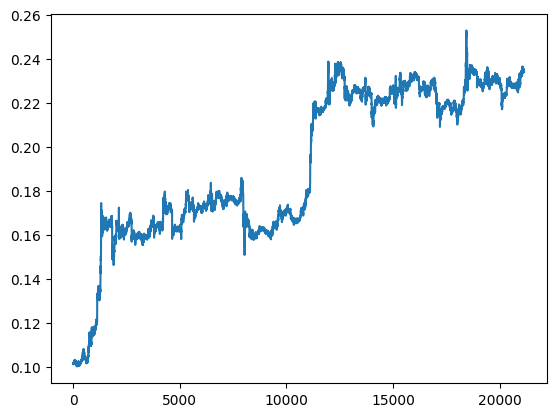

In [35]:
# Generate the predictions using your model and store it in a variable called 'predictions'


actual = close[num_train_samples+180:num_train_samples + num_val_samples+1]


timeframe= 50 * 24*60
start= timeframe * 2
end= start + timeframe
print(timeframe)
print(end-start)
print(start)
# Plot the actual data
plt.plot(range(len(actual[start:end])), actual[start:end], label='Actual Data')

# Plot the predicted data
plt.plot(range(len(actual[start:end])), predictions[start:end], label='Predicted Data')

# Add labels, title, and legend
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Actual vs Predicted Data')
plt.legend()

# Display the plot
plt.show()

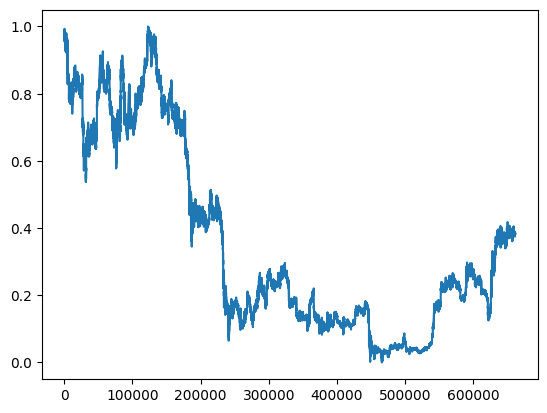

In [15]:


from matplotlib import pyplot as plt
plt.plot(range(len(close)), close)
